# Jaccard Sim between Inputs and Whole brain
1. Filter the whole brain dataframe for just the neurons in the input connectome data
    
    a. We are comparing the coarse modules to all the resolutions of the whole brain filtered data

2. Adjust the functions to be able to pull from two data frames to create the zero and new set

In [2]:
# Import partition data
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt



In [95]:
wbs = pd.read_csv('hemibrain/preprocessed-v1.2/preprocessed_nodes.csv')

wbs

,id,0.75,0.05,0.1,0.25,0.5,1.0,0.0,instance,celltype,...,size,status,cropped,statusLabel,cellBodyFiber,somaRadius,somaLocation,inputRois,outputRois,roiInfo
0,200326126,1,1,1,1,1,1,1,CL141_L,CL141,...,827930581,Traced,False,Roughly traced,PDL20,251.0,"[3844, 14565, 15568]","['AVLP(R)', 'IB', 'ICL(R)', 'INP', 'LH(R)', 'M...","['AVLP(R)', 'ICL(R)', 'INP', 'LH(R)', 'MB(+ACA...","{'SNP(R)': {'pre': 17, 'post': 19, 'downstream..."
1,202916528,2,2,2,2,2,2,2,FS4C(FQ12)_C4_R,FS4C,...,235674230,Traced,False,Roughly traced,PDM03,301.0,"[20091, 12266, 12208]","['CX', 'FB', 'FB-column3', 'FBl1', 'FBl2', 'FB...","['CX', 'FB', 'FBl7', 'SMP(L)', 'SNP(L)']","{'SNP(L)': {'pre': 93, 'post': 35, 'downstream..."
2,203253072,3,2,3,3,3,3,2,FS4A(AB)(FQ12)_C3_R,FS4A,...,154283963,Traced,False,Roughly traced,PDM03,236.0,"[17809, 10233, 14208]","['AB(R)', 'CRE(-RUB)(L)', 'CRE(L)', 'CX', 'FB'...","['AB(R)', 'CX', 'FB', 'FB-column3', 'FBl1', 'F...","{'SNP(L)': {'pre': 52, 'post': 30, 'downstream..."
3,203253253,4,3,3,4,4,4,2,SMP505(PDM22)_L,SMP505,...,1763416504,Traced,False,Roughly traced,NaN,351.0,"[32168, 13757, 13336]","['ATL(L)', 'CRE(-RUB)(L)', 'CRE(L)', 'ICL(L)',...","['SIP(L)', 'SIP(R)', 'SLP(R)', 'SMP(L)', 'SMP(...","{'SNP(L)': {'pre': 150, 'post': 2282, 'downstr..."
4,203257652,5,2,3,2,2,2,2,FS4C(FQ12)_C6_R,FS4C,...,209983364,Traced,False,Roughly traced,PDM02,301.0,"[22758, 16749, 10240]","['CX', 'FB', 'FBl1', 'FBl2', 'FBl3', 'FBl4', '...","['SIP(L)', 'SMP(L)', 'SNP(L)']","{'SNP(L)': {'pre': 65, 'post': 36, 'downstream..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21734,7112579856,2322,1,1,157,1064,3243,1,LC20,LC20,...,462394896,Traced,False,Roughly traced,NaN,301.5,"[7883, 23524, 33072]","['LO(R)', 'OL(R)', 'PLP(R)', 'VLNP(R)']","['LO(R)', 'OL(R)', 'PLP(R)', 'VLNP(R)']","{'OL(R)': {'pre': 268, 'post': 594, 'downstrea..."
21735,7112615127,2670,9,19,46,226,3110,6,AVLP335_R,AVLP335,...,453081149,Traced,False,Roughly traced,AVL13,NaN,NaN,"['AVLP(R)', 'PVLP(R)', 'VLNP(R)']","['AVLP(R)', 'PVLP(R)', 'VLNP(R)']","{'VLNP(R)': {'pre': 362, 'post': 577, 'downstr..."
21736,7112617294,2386,9,19,46,226,3362,6,AVLP331_R,AVLP331,...,438751734,Traced,False,Roughly traced,AVL13,NaN,NaN,"['AVLP(R)', 'PVLP(R)', 'VLNP(R)']","['AVLP(R)', 'PVLP(R)', 'VLNP(R)']","{'VLNP(R)': {'pre': 285, 'post': 661, 'downstr..."
21737,7112622044,879,3,8,14,120,2836,3,LAL137(PVL05)_L,LAL137,...,1529252938,Traced,False,Roughly traced,NaN,NaN,NaN,"['CRE(-ROB,-RUB)(R)', 'CRE(-RUB)(L)', 'CRE(L)'...","['CRE(-ROB,-RUB)(R)', 'CRE(-RUB)(L)', 'CRE(L)'...","{'SNP(R)': {'pre': 304, 'post': 130, 'downstre..."


## Filter wholebrain dataframe for the neurons that are in the input dataframe

In [113]:
# dataframes for the combined data
df_in = pd.read_csv('oviIN_combined/preprocessed_inputs-v1.2.1/preprocessed_nodes.csv', index_col=1)

# bodyIds from the inputs
ids = df_in['id']

# Filter the wb data to only include the bodyIds from the inputs
wb = wbs[wbs['id'].isin(ids)]
ids

 key
1       1003215282
2       1005952640
3       1006928515
4       1007260806
5       1007644534
           ...    
3739     988567837
3740     988653659
3741     988654188
3742     988909130
3743     989228019
Name: id, Length: 3743, dtype: int64

In [110]:
# Compare difference wb.index and ids
diff = set(ids) - set(wb['id'])


## Adjust Function to compare to WB zero set

In [115]:
# create a function that takes in two lists of id numbers and returns the jaccard sim of the two lists
def calculate_difference(list1, list2):
    set1 = set(list1)
    set2 = set(list2)

    unique_1 = set1-set2
    unique_2 = set2-set1

    # Union of set1 and set 2
    union_1_2 = set1 | set2
    common = set1.intersection(set2)
    jaccard_sim = len(common) / len(union_1_2)

    return unique_1, unique_2, common, jaccard_sim

# function that takes in a partition dataframe, the modules at the base resolution, and the chi value at which to compare
def get_body_ids(df, coarse_modules, chi):
    """ This function takes in a partition dataframe, the modules at the base resolution, and the chi value at which to compare. 
    It returns a dictionary of body IDs for each cluster number at the resolution and a dictionary of body IDs for each cluster 
    number at the base resolution."""

    # Gets cluster numbers for resolution
    chi_values = [chi]
    cluster_all = np.zeros((len(coarse_modules),len(chi_values), 800))
    for i, x in enumerate(coarse_modules):
        df_test = df[df['0.0']==x]
        for f, y in enumerate(chi_values):
            cluster = df_test[y].unique()
            cluster_all[i,f, :len(cluster)] = cluster

    # move everything to a dictionary
    dict = {}
    for i, x in enumerate(coarse_modules):
        dict[coarse_modules[i]] = cluster_all[i,0]
    
    # Remove the zeros from the array
    for key, value in dict.items():
        dict[key] = value[value != 0]
        dict[key] = np.array(value, dtype='int64')
    
    # Get bodyIDs for each cluster number in the resolution
    dict_new = {1: [], 2: [], 3: [], 4: [], 5: [], 6: []}
    for key, value in dict.items():
        body_ids = []
        for i, x in enumerate(value):
            body_ids.extend(df[df[chi]==x].index.tolist())
        dict_new[key] = body_ids

    return dict_new

# Function returns the zero set of the dataframe given
def get_zero_set(df):
       # Need bodyIds at zero resolution for each cluster number
    dict_zero = {1: [], 2: [], 3: [], 4: [], 5: [], 6: []}
    for key, value in dict_zero.items():
        dict_zero[key] = df[df['0.0']==key].index.tolist()
    return dict_zero
    
# Function that takes in partition dataframe, the modules at the base resolution, and the chi value at which to compare
def main_jaccard(df_zero, df, coarse_modules, chi):
    """ This function takes in a partition dataframe, the modules at the base resolution, and the chi 
    value at which to compare. It returns a dataframe of the jaccard similarities between the resolutions at each cluster"""

    # Get the body IDs for each cluster number at the resolution and the base resolution
    dict_new = get_body_ids(df, coarse_modules, chi)
    dict_zero = get_zero_set(df_zero)

    # Create a dictionary to store the jaccard similarities
    jaccard_dict = {}
    for key, value in dict_new.items():
        jaccard_dict[key] = []
        unique_1, unique_2, common, jaccard_sim = calculate_difference(dict_new[key], dict_zero[key])
        jaccard_dict[key].append(jaccard_sim)
    
    # Create a dataframe to store the jaccard similarities
    df_jaccard = pd.DataFrame(jaccard_dict)
    df_jaccard.index = np.arange(1, len(df_jaccard)+1)
    
    return df_jaccard

In [116]:
# Running jaccard
coarse_modules = [1, 2, 3, 4, 5, 6]
chi = '0.0'
df_jaccard = main_jaccard(df_in, wb, coarse_modules, '0.05')
df_jaccard1 = main_jaccard(df_in, wb, coarse_modules, '0.1')
df_jaccard_25 = main_jaccard(df_in, wb, coarse_modules, '0.25')
df_jaccard_50 = main_jaccard(df_in, wb, coarse_modules, '0.5')
df_jaccard_75 = main_jaccard(df_in, wb, coarse_modules, '0.75')
df_jaccard10 = main_jaccard(df_in, wb, coarse_modules, '1.0')


In [117]:
# Combine all dataframes
jaccard_values = df_jaccard._append([df_jaccard1, df_jaccard_25, df_jaccard_50, df_jaccard_75, df_jaccard10])
jaccard_values = jaccard_values.T
jaccard_values.columns = ['0.05', '0.1', '0.25', '0.5', '0.75', '1.0']


In [118]:
jaccard_values

,0.05,0.1,0.25,0.5,0.75,1.0
1,0.045655,0.045382,0.036769,0.021181,0.007837,0.006509
2,0.014435,0.039357,0.006452,0.005291,0.005386,0.005430
3,0.019811,0.019728,0.020212,0.019778,0.020000,0.021382
4,0.056395,0.057069,0.036669,0.029670,0.014728,0.011994
5,0.000000,0.000000,0.030988,0.006446,0.000000,0.000000
6,0.005952,0.005658,0.004942,0.004196,0.000000,0.000000


### Comparing combined data to WB 

Text(0.5, 1.0, 'Input Clusters Compared to WB clusters as WB Resolution Changes')

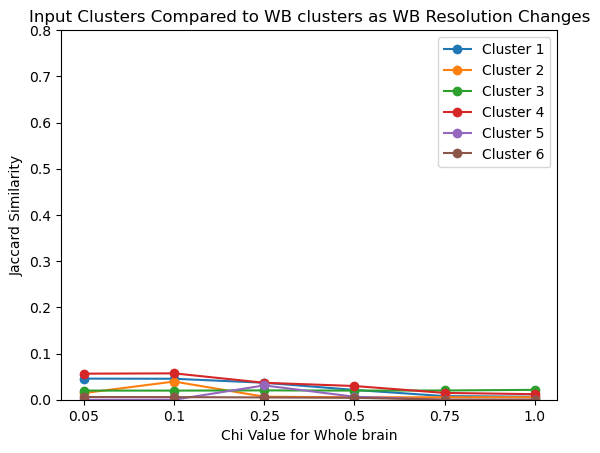

In [119]:
fig, ax  = plt.subplots()
for i in range(0, 6):
    ax.plot(jaccard_values.columns, jaccard_values.iloc[i], marker = "o", label=f'Cluster {i+1}')

ax.set_ylim(0, 0.8)
ax.legend()
ax.set_ylabel('Jaccard Similarity')
ax.set_xlabel('Chi Value for Whole brain')
ax.set_title('Input Clusters Compared to WB clusters as WB Resolution Changes')

### Comparing oviINr inputs to WB

In [91]:
df_inr = pd.read_csv('oviIN_june29/preprocessed_inputs-v1.2.1/preprocessed_nodes.csv', index_col=1)
wbs

,id,0.75,0.05,0.1,0.25,0.5,1.0,0.0,instance,celltype,...,size,status,cropped,statusLabel,cellBodyFiber,somaRadius,somaLocation,inputRois,outputRois,roiInfo
0,200326126,1,1,1,1,1,1,1,CL141_L,CL141,...,827930581,Traced,False,Roughly traced,PDL20,251.0,"[3844, 14565, 15568]","['AVLP(R)', 'IB', 'ICL(R)', 'INP', 'LH(R)', 'M...","['AVLP(R)', 'ICL(R)', 'INP', 'LH(R)', 'MB(+ACA...","{'SNP(R)': {'pre': 17, 'post': 19, 'downstream..."
1,202916528,2,2,2,2,2,2,2,FS4C(FQ12)_C4_R,FS4C,...,235674230,Traced,False,Roughly traced,PDM03,301.0,"[20091, 12266, 12208]","['CX', 'FB', 'FB-column3', 'FBl1', 'FBl2', 'FB...","['CX', 'FB', 'FBl7', 'SMP(L)', 'SNP(L)']","{'SNP(L)': {'pre': 93, 'post': 35, 'downstream..."
2,203253072,3,2,3,3,3,3,2,FS4A(AB)(FQ12)_C3_R,FS4A,...,154283963,Traced,False,Roughly traced,PDM03,236.0,"[17809, 10233, 14208]","['AB(R)', 'CRE(-RUB)(L)', 'CRE(L)', 'CX', 'FB'...","['AB(R)', 'CX', 'FB', 'FB-column3', 'FBl1', 'F...","{'SNP(L)': {'pre': 52, 'post': 30, 'downstream..."
3,203253253,4,3,3,4,4,4,2,SMP505(PDM22)_L,SMP505,...,1763416504,Traced,False,Roughly traced,NaN,351.0,"[32168, 13757, 13336]","['ATL(L)', 'CRE(-RUB)(L)', 'CRE(L)', 'ICL(L)',...","['SIP(L)', 'SIP(R)', 'SLP(R)', 'SMP(L)', 'SMP(...","{'SNP(L)': {'pre': 150, 'post': 2282, 'downstr..."
4,203257652,5,2,3,2,2,2,2,FS4C(FQ12)_C6_R,FS4C,...,209983364,Traced,False,Roughly traced,PDM02,301.0,"[22758, 16749, 10240]","['CX', 'FB', 'FBl1', 'FBl2', 'FBl3', 'FBl4', '...","['SIP(L)', 'SMP(L)', 'SNP(L)']","{'SNP(L)': {'pre': 65, 'post': 36, 'downstream..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21734,7112579856,2322,1,1,157,1064,3243,1,LC20,LC20,...,462394896,Traced,False,Roughly traced,NaN,301.5,"[7883, 23524, 33072]","['LO(R)', 'OL(R)', 'PLP(R)', 'VLNP(R)']","['LO(R)', 'OL(R)', 'PLP(R)', 'VLNP(R)']","{'OL(R)': {'pre': 268, 'post': 594, 'downstrea..."
21735,7112615127,2670,9,19,46,226,3110,6,AVLP335_R,AVLP335,...,453081149,Traced,False,Roughly traced,AVL13,NaN,NaN,"['AVLP(R)', 'PVLP(R)', 'VLNP(R)']","['AVLP(R)', 'PVLP(R)', 'VLNP(R)']","{'VLNP(R)': {'pre': 362, 'post': 577, 'downstr..."
21736,7112617294,2386,9,19,46,226,3362,6,AVLP331_R,AVLP331,...,438751734,Traced,False,Roughly traced,AVL13,NaN,NaN,"['AVLP(R)', 'PVLP(R)', 'VLNP(R)']","['AVLP(R)', 'PVLP(R)', 'VLNP(R)']","{'VLNP(R)': {'pre': 285, 'post': 661, 'downstr..."
21737,7112622044,879,3,8,14,120,2836,3,LAL137(PVL05)_L,LAL137,...,1529252938,Traced,False,Roughly traced,NaN,NaN,NaN,"['CRE(-ROB,-RUB)(R)', 'CRE(-RUB)(L)', 'CRE(L)'...","['CRE(-ROB,-RUB)(R)', 'CRE(-RUB)(L)', 'CRE(L)'...","{'SNP(R)': {'pre': 304, 'post': 130, 'downstre..."


Text(0.5, 1.0, 'Input Clusters Compared to WB clusters as Input Resolution Changes')

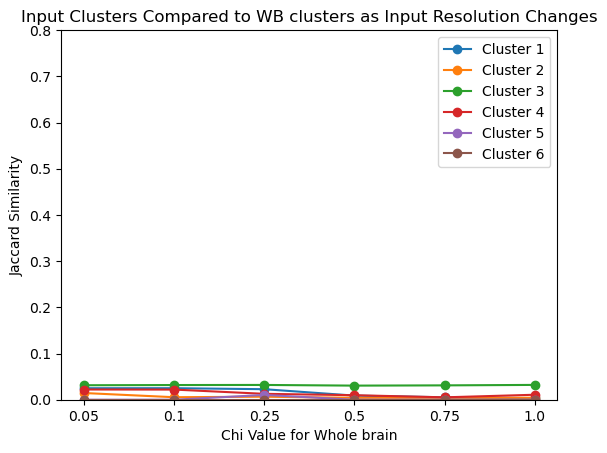

In [92]:
df_inr = pd.read_csv('oviIN_june29/preprocessed_inputs-v1.2.1/preprocessed_nodes.csv', index_col=1)
wbs = pd.read_csv('hemibrain/preprocessed-v1.2/preprocessed_nodes.csv')
# bodyIds from the inputs
ids = df_inr['id']

# Filter the wb data to only include the bodyIds from the inputs
wb = wbs[wbs['id'].isin(ids)]

# Running jaccard
coarse_modules = [1, 2, 3, 4, 5, 6]

df_jaccardr = main_jaccard(df_inr, wb, coarse_modules, '0.05')
df_jaccard1r = main_jaccard(df_inr, wb, coarse_modules, '0.1')
df_jaccard_25r = main_jaccard(df_inr, wb, coarse_modules, '0.25')
df_jaccard_50r = main_jaccard(df_inr, wb, coarse_modules, '0.5')
df_jaccard_75r = main_jaccard(df_inr, wb, coarse_modules, '0.75')
df_jaccard10r = main_jaccard(df_inr, wb, coarse_modules, '1.0')

# Combine all dataframes
jaccard_valuesr = df_jaccardr._append([df_jaccard1r, df_jaccard_25r, df_jaccard_50r, df_jaccard_75r, df_jaccard10r])
jaccard_valuesr = jaccard_valuesr.T
jaccard_valuesr.columns = ['0.05', '0.1', '0.25', '0.5', '0.75', '1.0']

fig, ax  = plt.subplots()
for i in range(0, 6):
    ax.plot(jaccard_valuesr.columns, jaccard_valuesr.iloc[i], marker = "o", label=f'Cluster {i+1}')

ax.set_ylim(0, 0.8)
ax.legend()
ax.set_ylabel('Jaccard Similarity')
ax.set_xlabel('Chi Value for Whole brain')
ax.set_title('Input Clusters Compared to WB clusters as Input Resolution Changes')


In [82]:
df_inr

,id,0.0,0.05,0.1,0.5,0.75,1.0,instance,celltype,pre,...,status,cropped,statusLabel,cellBodyFiber,somaRadius,somaLocation,roiInfo,notes,inputRois,outputRois
key,,,,,,,,,,,,,,,,,,,,,
1,1003215282,1,1,1,1,1,1,CL229_R,CL229,100,...,Traced,False,Roughly traced,PDM19,301.0,"[23044, 14981, 11600]","{'INP': {'pre': 87, 'post': 351, 'downstream':...",NaN,"['EPA(R)', 'GOR(R)', 'IB', 'ICL(R)', 'INP', 'S...","['GOR(R)', 'IB', 'ICL(R)', 'INP', 'SCL(R)', 'S..."
2,1005952640,2,1,1,2,2,2,IB058_R,IB058,664,...,Traced,False,Roughly traced,PVL20,NaN,NaN,"{'INP': {'pre': 464, 'post': 1327, 'downstream...",NaN,"['ATL(R)', 'IB', 'ICL(R)', 'INP', 'PLP(R)', 'S...","['ATL(R)', 'IB', 'ICL(R)', 'INP', 'PLP(R)', 'S..."
3,1006928515,1,1,1,3,3,3,CL300_R,CL300,86,...,Traced,False,Roughly traced,PVL13,236.0,"[12083, 10523, 16816]","{'INP': {'pre': 79, 'post': 126, 'downstream':...",NaN,"['ATL(R)', 'IB', 'ICL(R)', 'INP', 'SCL(R)', 'S...","['ATL(R)', 'IB', 'ICL(R)', 'INP', 'SCL(R)', 'S..."
4,1007260806,2,1,1,4,4,4,CL301_R,CL301,119,...,Traced,False,Roughly traced,PVL13,236.0,"[13524, 10108, 16480]","{'INP': {'pre': 40, 'post': 128, 'downstream':...",NaN,"['GOR(R)', 'IB', 'ICL(R)', 'INP', 'PLP(R)', 'S...","['IB', 'ICL(R)', 'INP', 'PLP(R)', 'SCL(R)', 'S..."
5,1008024276,3,2,2,5,5,5,FB5N_R,FB5N,499,...,Traced,False,Roughly traced,AVM08,472.5,"[19178, 29711, 37312]","{'SNP(L)': {'post': 5, 'upstream': 5, 'mito': ...",SMPCREFB5_4,"['CRE(-ROB,-RUB)(R)', 'CRE(R)', 'CX', 'FB', 'F...","['CRE(-ROB,-RUB)(R)', 'CRE(R)', 'CX', 'FB', 'F..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2507,987273073,3,8,8,409,604,629,(PVL05)_L,None,283,...,Traced,False,Roughly traced,NaN,NaN,NaN,"{'SNP(R)': {'pre': 65, 'post': 52, 'downstream...",NaN,"['CRE(-ROB,-RUB)(R)', 'CRE(-RUB)(L)', 'CRE(L)'...","['CRE(-ROB,-RUB)(R)', 'CRE(-RUB)(L)', 'CRE(L)'..."
2508,987842109,3,9,23,533,780,815,None,None,2,...,Orphan,NaN,Orphan hotknife,NaN,NaN,NaN,"{'SNP(R)': {'pre': 2, 'post': 13, 'downstream'...",NaN,"['SMP(R)', 'SNP(R)']","['SMP(R)', 'SNP(R)']"
2509,988567837,2,3,4,16,58,63,FB4G_R,FB4G,785,...,Traced,False,Roughly traced,AVM08,NaN,NaN,"{'SNP(R)': {'pre': 6, 'post': 73, 'downstream'...",CRELALFB4_3,"['CRE(-ROB,-RUB)(R)', 'CRE(R)', 'CX', 'FB', 'F...","['CRE(-ROB,-RUB)(R)', 'CRE(R)', 'CX', 'FB', 'F..."


In [74]:
wb

,0.75,0.05,0.1,0.25,0.5,1.0,0.0,instance,celltype,pre,...,size,status,cropped,statusLabel,cellBodyFiber,somaRadius,somaLocation,inputRois,outputRois,roiInfo
id,,,,,,,,,,,,,,,,,,,,,
263674097,19,3,8,14,16,22,3,LHPD2a5_a_R,LHPD2a5_a,133,...,408560985,Traced,False,Roughly traced,PDL06,268.5,"[5386, 20096, 4080]","['CRE(-ROB,-RUB)(R)', 'CRE(R)', 'INP', 'LH(R)'...","['INP', 'LH(R)', 'SCL(R)', 'SIP(R)', 'SMP(R)',...","{'SNP(R)': {'pre': 121, 'post': 330, 'downstre..."
266187480,30,3,8,4,23,35,3,SMP349_R,SMP349,190,...,563941715,Traced,False,Traced,PDM07,238.5,"[18808, 27714, 4256]","['SIP(R)', 'SLP(R)', 'SMP(R)', 'SNP(R)']","['SIP(R)', 'SLP(R)', 'SMP(R)', 'SNP(R)']","{'SNP(R)': {'pre': 190, 'post': 854, 'downstre..."
266187559,32,3,8,4,25,37,3,SLP399_R,SLP399,216,...,539797068,Traced,False,Roughly traced,PDM07,290.5,"[17838, 26568, 3924]","['LH(R)', 'SLP(R)', 'SMP(R)', 'SNP(R)']","['SLP(R)', 'SMP(R)', 'SNP(R)']","{'SNP(R)': {'pre': 216, 'post': 744, 'downstre..."
267214250,42,3,8,22,33,47,3,pC1b_R,pC1b,816,...,3805489752,Traced,False,Traced,PDM09,446.5,"[18931, 10896, 14728]","['AOTU(R)', 'AVLP(R)', 'ICL(R)', 'INP', 'SCL(R...","['AVLP(R)', 'INP', 'SCL(R)', 'SIP(R)', 'SLP(R)...","{'SNP(R)': {'pre': 547, 'post': 2474, 'downstr..."
267223104,44,6,7,19,34,49,4,SMP025_R,SMP025,97,...,383479545,Traced,False,Roughly traced,ADL09,286.0,"[3281, 26379, 16668]","['SIP(R)', 'SLP(R)', 'SMP(R)', 'SNP(R)']","['SIP(R)', 'SLP(R)', 'SMP(R)', 'SNP(R)']","{'SNP(R)': {'pre': 97, 'post': 410, 'downstrea..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5901225755,2285,1,1,98,1221,3714,1,None,None,465,...,809456817,Traced,False,Roughly traced,NaN,NaN,NaN,"['ATL(R)', 'IB', 'ICL(R)', 'INP', 'IPS(R)', 'L...","['ATL(R)', 'IB', 'ICL(R)', 'INP', 'IPS(R)', 'L...","{'INP': {'pre': 123, 'post': 475, 'downstream'..."
5901227238,2672,7,33,107,1170,3208,1,None,None,185,...,773291310,Traced,False,Roughly traced,NaN,NaN,NaN,"['AL(R)', 'AL-VP2(R)', 'EPA(R)', 'IPS(R)', 'LA...","['EPA(R)', 'IPS(R)', 'LAL(-GA)(R)', 'LAL(R)', ...","{'LX(R)': {'pre': 42, 'post': 557, 'downstream..."
5901232053,155,3,8,4,65,178,3,SMP272(PDL21)_L,SMP272,1064,...,1421485085,Traced,False,Roughly traced,NaN,NaN,NaN,"['CRE(-RUB)(L)', 'CRE(L)', 'INP', 'LAL(L)', 'L...","['CRE(-RUB)(L)', 'CRE(L)', 'INP', 'SCL(L)', 'S...","{'SNP(L)': {'pre': 464, 'post': 967, 'downstre..."
